In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


In [2]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()

    return fix_df

In [3]:
# 读取数据
his_nmp_fd_df = pd.read_csv('.\\data\\FD001\\03 His_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_power_fd_df = pd.read_csv('.\\data\\FD001\\02_His_Power_FD.csv',parse_dates=["Datetime"],index_col=[0])
his_fd_df=preprocessing(his_nmp_fd_df,his_power_fd_df)
his_fd_df.to_csv('his_df.csv',encoding = 'utf-8') #存储合并后数据

In [4]:
df=pd.read_csv('his_df.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-15 00:00:00,3.3696,290.3172,4.1829,295.0334,4.9253,297.9698,5.6139,300.0360,6.2446,301.5774,6.5423,302.1353,27.59,1003.96,93.20,0.0216
2022-07-15 00:15:00,3.3092,291.4477,4.1100,296.1286,4.8389,299.0546,5.5137,301.1241,6.1388,302.6287,6.4347,303.2702,27.61,1004.37,93.05,0.0218
2022-07-15 00:30:00,3.4671,295.0868,4.2669,299.3285,5.0000,302.0054,5.6718,303.8582,6.2926,305.2307,6.5832,305.7906,27.62,1004.25,92.96,0.4021
2022-07-15 00:45:00,3.6896,296.9123,4.4933,300.7888,5.2253,303.4468,5.9067,305.1430,6.5341,306.5367,6.8241,307.1386,27.62,1003.96,92.82,0.5867
2022-07-15 01:00:00,3.7095,298.4995,4.5220,302.3546,5.2791,304.8942,5.9740,306.6973,6.6113,307.9966,6.9170,308.5434,27.64,1003.68,92.59,0.3889


In [5]:
df.tail()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597
2022-07-21 23:30:00,3.2299,299.8989,4.5556,308.4045,5.8027,312.7652,6.6115,314.9387,6.7961,315.8942,6.8890,316.2939,27.46,1009.84,0.00,3.4466
2022-07-21 23:45:00,3.4215,297.3140,4.7503,306.2668,6.0103,311.0873,6.7556,313.3806,6.9372,314.3576,7.0216,314.8269,27.46,1009.69,0.00,3.0725


In [6]:
df.shape

(672, 16)

In [7]:
# 划分train valid test集
fd_df_train = df[:int(0.6*len(df))]
fd_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
fd_df_test =df[int(0.8*len(df)):]

In [8]:
# # 划分train valid test集
# fd_df_train = df[:int(0.6*len(df))]
# fd_df_valid = df[int(0.8*len(df)):]
# fd_df_test =df[int(0.8*len(df)):]

In [9]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)

df_for_training_scaled = scaler.transform(fd_df_train)
df_for_validing_scaled=scaler.transform(fd_df_valid)
df_for_testing_scaled=scaler.transform(fd_df_test)

In [10]:
df_scaled=scaler.transform(df)

In [11]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

In [12]:
df_X,df_y=createXY(np.array(df))

In [13]:
df_scaled_X,df_scaled_y=createXY(np.array(df_scaled))

In [14]:
train_X.shape

(396, 7, 16)

In [15]:
train_y.shape

(396,)

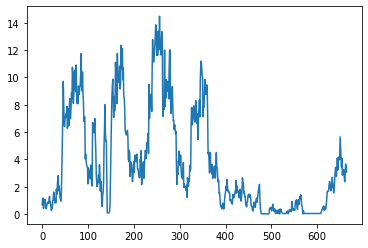

In [16]:
plt.plot(range(len(df_y)), df_y, label='history')

In [17]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=(abs(np.array(y_true) - np.array(y_predict.flatten()))).sum()
    return float(difference) 

In [18]:

def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    
    return grid_model

In [19]:
bestscore=1000
bestmodel=[]
flag=0


In [20]:
i=0
best_size=0
best_batch_size=0
best_epochs=0
for size in [64,32]:
    for batch_size in [16,32]:
        for epochs in [40]:
            grid_model=build_model(size)
            grid_model.fit(
            train_X, train_y,
            validation_data=(valid_X, valid_y),
            batch_size=32,
            epochs=epochs,
            verbose=0)
            pred_valid_y = grid_model.predict(valid_X)
            score=ev(valid_y,pred_valid_y)
            print(score,'num:',i,'size=',size,'batch_size=',batch_size,'epochs=',epochs)
            i=i+1
            if score<bestscore:
                flag=1
                bestscore=score
                best_size=size
                best_batch_size=batch_size
                best_epochs=epochs
                # Export the model to a SavedModel
                grid_model.save('keras_model_tf_version', save_format='tf')
print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)

3.0725757397567413 num: 0 size= 64 batch_size= 16 epochs= 40


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


3.0725757397567413 num: 1 size= 64 batch_size= 32 epochs= 40
3.1776513310146957 num: 2 size= 32 batch_size= 16 epochs= 40
3.1776513310146957 num: 3 size= 32 batch_size= 32 epochs= 40
3.0725757397567413 best_size= 64 best_batch_size= 16 best_epochs= 40


In [21]:
# Recreate the exact same model
my_model = tf.keras.models.load_model('keras_model_tf_version')
new_pred_valid_y=my_model.predict(valid_X)
score=ev(valid_y,new_pred_valid_y)
score

3.0725757397567413

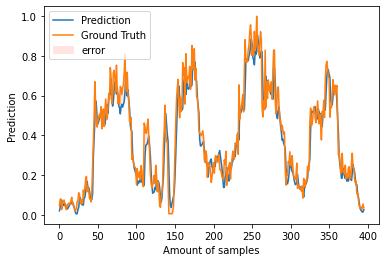

In [22]:
# 查看train集预测结果
pred_train_y = my_model.predict(train_X)
plt.plot(range(len(pred_train_y)), pred_train_y, label='Prediction')
plt.plot(range(len(pred_train_y)), train_y, label='Ground Truth')
plt.fill_between(range(len(pred_train_y)), pred_train_y.flatten(), train_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

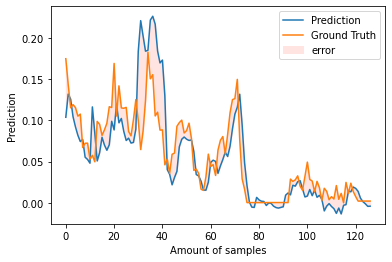

In [23]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [24]:
ev(valid_y,pred_valid_y)

3.0725757397567413

In [25]:
# %%
# Predicting
pred_y = my_model.predict(test_X)


In [26]:
pred_y.flatten()

array([-2.12248880e-03, -2.93985475e-03, -4.74690553e-03, -2.30859499e-03,
        3.55632976e-04,  4.43408825e-03,  9.58988164e-03,  1.20553412e-02,
        2.03046538e-02,  4.34735045e-02,  3.26063074e-02,  1.97546855e-02,
        2.11434066e-02,  2.60672122e-02,  2.56128572e-02,  2.45147832e-02,
        4.33637314e-02,  7.14951530e-02,  6.34269938e-02,  7.14113712e-02,
        5.48814610e-02,  3.25733274e-02,  4.29153629e-02,  5.59566505e-02,
        4.71250601e-02,  5.09729311e-02,  6.81361407e-02,  6.88067526e-02,
        7.95726329e-02,  1.03272237e-01,  8.83882642e-02,  7.85845667e-02,
        5.02117462e-02,  2.58974358e-02,  3.22629474e-02,  2.61872448e-02,
        1.24425106e-02,  5.42113883e-03,  5.55824954e-03,  1.12018231e-02,
        1.43674901e-02,  2.62634344e-02,  1.86981373e-02,  1.60817988e-02,
        1.19548133e-02,  7.69498292e-04,  6.39297999e-04, -2.40136590e-03,
       -5.78514952e-03, -6.42160885e-03, -6.17806800e-03, -4.39085346e-03,
       -3.04737780e-03,  

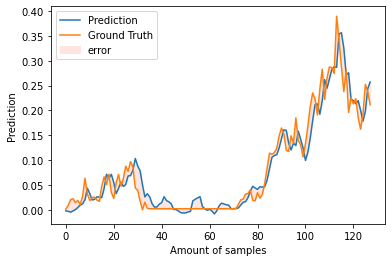

In [27]:
# %% Plotting
plt.plot(range(len(pred_y)), pred_y, label='Prediction')
plt.plot(range(len(pred_y)), test_y, label='Ground Truth')
plt.fill_between(range(len(pred_y)), pred_y.flatten(), test_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()
# %%

In [28]:
# prediction of feature
df_30_days_past=df.iloc[-7:,:]
df_30_days_past.tail()

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597
2022-07-21 23:30:00,3.2299,299.8989,4.5556,308.4045,5.8027,312.7652,6.6115,314.9387,6.7961,315.8942,6.8890,316.2939,27.46,1009.84,0.00,3.4466
2022-07-21 23:45:00,3.4215,297.3140,4.7503,306.2668,6.0103,311.0873,6.7556,313.3806,6.9372,314.3576,7.0216,314.8269,27.46,1009.69,0.00,3.0725


In [29]:
df_30_days_future=pd.read_csv('.\\data\\FD001\\04 Fore_NWP_FD.csv',parse_dates=["Datetime"],index_col=[0])
df_30_days_future
df_30_days_future.shape

(672, 15)

In [30]:
df_30_days_future["Power(MW)"]=0

In [31]:
df_30_days_future

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-22 00:00:00,3.7211,295.8076,5.0066,304.4201,6.2332,309.2053,7.0688,311.6739,7.2327,312.6467,7.3154,313.1167,27.48,1009.94,91.75,0
2022-07-22 00:15:00,3.8066,293.5346,5.0170,301.8843,6.1681,306.6284,7.2085,309.6529,7.3615,310.5929,7.4355,311.0192,27.50,1010.59,91.66,0
2022-07-22 00:30:00,3.6731,294.9604,4.9233,302.9800,6.1044,307.5457,7.1653,310.3584,7.3207,311.1786,7.4027,311.5500,27.49,1010.61,91.58,0
2022-07-22 00:45:00,3.5422,297.2161,4.8605,305.0306,6.0974,309.2762,7.0755,311.7344,7.2339,312.4229,7.3028,312.7803,27.49,1010.30,91.49,0
2022-07-22 01:00:00,3.3743,298.6918,4.7401,306.5073,6.0209,310.6219,6.9490,312.7840,7.1021,313.4025,7.1718,313.7571,27.49,1010.12,91.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28 22:45:00,3.2940,53.2693,3.4840,49.7733,3.6509,46.9979,3.8255,44.6823,3.9843,42.6606,4.0584,41.7039,28.85,1004.59,85.20,0
2022-07-28 23:00:00,3.1397,55.9050,3.3223,52.3368,3.5110,49.5049,3.6723,47.0966,3.8396,45.1055,3.9178,44.1727,28.87,1004.80,85.14,0
2022-07-28 23:15:00,3.0180,57.3104,3.2122,53.7366,3.4047,50.8408,3.5776,48.5128,3.7421,46.6242,3.8258,45.7413,28.88,1004.96,85.25,0


In [32]:
df_30_days_future=df_30_days_future[["Speed10" , "Direction10" , "Speed30" , "Direction30" , "Speed50" , "Direction50" , "Speed70" , "Direction70" , "Speed90" , "Direction90" , "Speed100" , "Direction100" , "Temper" , "Pressure" , "Humidity" , "Power(MW)"]]

In [33]:
df_30_days_future.shape

(672, 16)

In [34]:
df_30_days_future

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-22 00:00:00,3.7211,295.8076,5.0066,304.4201,6.2332,309.2053,7.0688,311.6739,7.2327,312.6467,7.3154,313.1167,27.48,1009.94,91.75,0
2022-07-22 00:15:00,3.8066,293.5346,5.0170,301.8843,6.1681,306.6284,7.2085,309.6529,7.3615,310.5929,7.4355,311.0192,27.50,1010.59,91.66,0
2022-07-22 00:30:00,3.6731,294.9604,4.9233,302.9800,6.1044,307.5457,7.1653,310.3584,7.3207,311.1786,7.4027,311.5500,27.49,1010.61,91.58,0
2022-07-22 00:45:00,3.5422,297.2161,4.8605,305.0306,6.0974,309.2762,7.0755,311.7344,7.2339,312.4229,7.3028,312.7803,27.49,1010.30,91.49,0
2022-07-22 01:00:00,3.3743,298.6918,4.7401,306.5073,6.0209,310.6219,6.9490,312.7840,7.1021,313.4025,7.1718,313.7571,27.49,1010.12,91.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28 22:45:00,3.2940,53.2693,3.4840,49.7733,3.6509,46.9979,3.8255,44.6823,3.9843,42.6606,4.0584,41.7039,28.85,1004.59,85.20,0
2022-07-28 23:00:00,3.1397,55.9050,3.3223,52.3368,3.5110,49.5049,3.6723,47.0966,3.8396,45.1055,3.9178,44.1727,28.87,1004.80,85.14,0
2022-07-28 23:15:00,3.0180,57.3104,3.2122,53.7366,3.4047,50.8408,3.5776,48.5128,3.7421,46.6242,3.8258,45.7413,28.88,1004.96,85.25,0


In [35]:
df

,Speed10,Direction10,Speed30,Direction30,Speed50,Direction50,Speed70,Direction70,Speed90,Direction90,Speed100,Direction100,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,,,,,,,,,,
2022-07-15 00:00:00,3.3696,290.3172,4.1829,295.0334,4.9253,297.9698,5.6139,300.0360,6.2446,301.5774,6.5423,302.1353,27.59,1003.96,93.20,0.0216
2022-07-15 00:15:00,3.3092,291.4477,4.1100,296.1286,4.8389,299.0546,5.5137,301.1241,6.1388,302.6287,6.4347,303.2702,27.61,1004.37,93.05,0.0218
2022-07-15 00:30:00,3.4671,295.0868,4.2669,299.3285,5.0000,302.0054,5.6718,303.8582,6.2926,305.2307,6.5832,305.7906,27.62,1004.25,92.96,0.4021
2022-07-15 00:45:00,3.6896,296.9123,4.4933,300.7888,5.2253,303.4468,5.9067,305.1430,6.5341,306.5367,6.8241,307.1386,27.62,1003.96,92.82,0.5867
2022-07-15 01:00:00,3.7095,298.4995,4.5220,302.3546,5.2791,304.8942,5.9740,306.6973,6.6113,307.9966,6.9170,308.5434,27.64,1003.68,92.59,0.3889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-21 22:45:00,4.5521,307.3230,6.1812,312.0492,7.6793,314.6835,8.4867,316.0503,8.6879,316.8657,8.7815,317.1689,27.90,1009.53,87.03,2.3584
2022-07-21 23:00:00,4.5931,308.9910,5.4076,312.4519,6.1518,314.8683,6.7197,316.4472,6.8998,317.2906,6.9864,317.6105,27.92,1010.14,0.00,2.8011
2022-07-21 23:15:00,3.3338,303.4994,4.6673,310.4815,5.9120,314.1776,6.7329,316.0832,6.9197,316.9911,7.0061,317.3137,27.44,1009.89,0.00,3.6597


In [36]:
old_scaled_array=scaler.transform(df_30_days_past)

In [37]:
old_scaled_array.shape

(7, 16)

In [38]:
old_scaled_array

array([[0.41404468, 0.8576025 , 0.54823153, 0.86705459, 0.6566292 ,
        0.87503566, 0.6649744 , 0.87578878, 0.64834984, 0.87772728,
        0.64099123, 0.87891673, 0.36672968, 0.91418248, 0.8577633 ,
        0.22369576],
       [0.40811116, 0.8561129 , 0.5389701 , 0.86691941, 0.64420575,
        0.8755703 , 0.66196274, 0.87698191, 0.64612546, 0.8790288 ,
        0.63887294, 0.88046241, 0.36294896, 0.93315266, 0.85865166,
        0.18583924],
       [0.40485176, 0.85521389, 0.53291131, 0.86737641, 0.63672364,
        0.87672373, 0.66022458, 0.87844592, 0.64458486, 0.88072337,
        0.63736912, 0.88188407, 0.36294896, 0.94489612, 0.85904649,
        0.16228176],
       [0.40898908, 0.85987377, 0.46046803, 0.86849653, 0.50289559,
        0.87723859, 0.50817881, 0.87954977, 0.49727307, 0.88190528,
        0.4922343 , 0.88311193, 0.36672968, 1.        , 0.        ,
        0.19289196],
       [0.28191285, 0.84453194, 0.39114312, 0.86301585, 0.48188612,
        0.87531427, 0.50931463, 

In [39]:
new_scaled_array=scaler.transform(df_30_days_future)

In [40]:
new_scaled_array.shape

(672, 16)

In [41]:
new_scaled_array

array([[ 3.20995378e-01,  8.23043425e-01,  4.22916647e-01, ...,
         9.81933153e-01,  9.05636166e-01, -7.88245462e-04],
       [ 3.29623201e-01,  8.16693365e-01,  4.23890548e-01, ...,
         1.04065041e+00,  9.04747804e-01, -7.88245462e-04],
       [ 3.16151688e-01,  8.20676610e-01,  4.15116072e-01, ...,
         1.04245709e+00,  9.03958148e-01, -7.88245462e-04],
       ...,
       [ 2.50045410e-01,  1.56755955e-01,  2.54881212e-01, ...,
         5.32068654e-01,  8.41476656e-01, -7.88245462e-04],
       [ 2.53456175e-01,  1.57889076e-01,  2.58879826e-01, ...,
         5.50135501e-01,  8.44931399e-01, -7.88245462e-04],
       [ 2.64596662e-01,  1.56628563e-01,  2.71400077e-01, ...,
         5.73622403e-01,  8.46214589e-01, -7.88245462e-04]])

In [42]:
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,-1]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
full_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.414045,0.857602,0.548232,0.867055,0.656629,0.875036,0.664974,0.875789,0.648350,0.877727,0.640991,0.878917,0.366730,0.914182,0.857763,0.223696
1,0.408111,0.856113,0.538970,0.866919,0.644206,0.875570,0.661963,0.876982,0.646125,0.879029,0.638873,0.880462,0.362949,0.933153,0.858652,0.185839
2,0.404852,0.855214,0.532911,0.867376,0.636724,0.876724,0.660225,0.878446,0.644585,0.880723,0.637369,0.881884,0.362949,0.944896,0.859046,0.162282
3,0.408989,0.859874,0.460468,0.868497,0.502896,0.877239,0.508179,0.879550,0.497273,0.881905,0.492234,0.883112,0.366730,1.000000,0.000000,0.192892
4,0.281913,0.844532,0.391143,0.863016,0.481886,0.875314,0.509315,0.878537,0.498913,0.881072,0.493827,0.882287,0.275992,0.977416,0.000000,0.252259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,0.277897,0.145466,0.280334,0.137854,0.283786,0.130938,0.259140,0.123722,0.257081,0.117988,0.255504,0.115957,0.542533,0.498645,0.840983,NaN
675,0.262326,0.152830,0.265191,0.144985,0.271529,0.137923,0.245958,0.130437,0.245160,0.124788,0.244136,0.122822,0.546314,0.517615,0.840391,NaN
676,0.250045,0.156756,0.254881,0.148878,0.262215,0.141645,0.237809,0.134375,0.237127,0.129013,0.236698,0.127183,0.548204,0.532069,0.841477,NaN
677,0.253456,0.157889,0.258880,0.151011,0.265913,0.144410,0.242533,0.137648,0.242672,0.132782,0.242026,0.130913,0.548204,0.550136,0.844931,NaN


In [43]:
full_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.414045,0.857602,0.548232,0.867055,0.656629,0.875036,0.664974,0.875789,0.648350,0.877727,0.640991,0.878917,0.366730,0.914182,0.857763,0.223696
1,0.408111,0.856113,0.538970,0.866919,0.644206,0.875570,0.661963,0.876982,0.646125,0.879029,0.638873,0.880462,0.362949,0.933153,0.858652,0.185839
2,0.404852,0.855214,0.532911,0.867376,0.636724,0.876724,0.660225,0.878446,0.644585,0.880723,0.637369,0.881884,0.362949,0.944896,0.859046,0.162282
3,0.408989,0.859874,0.460468,0.868497,0.502896,0.877239,0.508179,0.879550,0.497273,0.881905,0.492234,0.883112,0.366730,1.000000,0.000000,0.192892
4,0.281913,0.844532,0.391143,0.863016,0.481886,0.875314,0.509315,0.878537,0.498913,0.881072,0.493827,0.882287,0.275992,0.977416,0.000000,0.252259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,0.277897,0.145466,0.280334,0.137854,0.283786,0.130938,0.259140,0.123722,0.257081,0.117988,0.255504,0.115957,0.542533,0.498645,0.840983,NaN
675,0.262326,0.152830,0.265191,0.144985,0.271529,0.137923,0.245958,0.130437,0.245160,0.124788,0.244136,0.122822,0.546314,0.517615,0.840391,NaN
676,0.250045,0.156756,0.254881,0.148878,0.262215,0.141645,0.237809,0.134375,0.237127,0.129013,0.236698,0.127183,0.548204,0.532069,0.841477,NaN
677,0.253456,0.157889,0.258880,0.151011,0.265913,0.144410,0.242533,0.137648,0.242672,0.132782,0.242026,0.130913,0.548204,0.550136,0.844931,NaN


In [44]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=7
for i in range(time_step,len(full_df_scaled_array)):
      data_x=[]
      data_x.append( full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
      data_x=np.array(data_x)
      prediction=grid_model.predict(data_x)
      if prediction<0:
            prediction=0
      all_data.append(prediction)
      full_df.iloc[i,-1]=prediction
#       print('?',full_df_scaled_array[i,-1])
#       print(full_df.values[i,-1])

In [45]:
array1=np.array(all_data).flatten()

C:\Users\23966\AppData\Local\Temp\ipykernel_24864\3394579515.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array1=np.array(all_data).flatten()


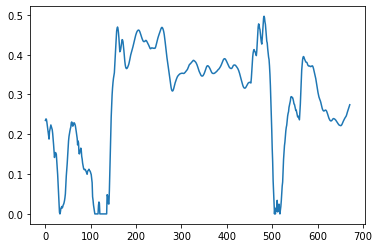

In [46]:
# 这是没有经过归一化逆变换的图
plt.plot(range(len(np.array(array1))), array1, label='Prediction')

In [47]:
# 这块地方涉及归一化的反变换，但是我感觉有点问题
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,16, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),16)))[:,0]
print(y_pred_future_30_days)

[2.86703928 2.90268489 2.90009938 2.84078975 2.75511808 2.66421158
 2.57090077 2.47745705 2.40312476 2.58556474 2.64574842 2.70301005
 2.75447764 2.71715659 2.68740897 2.6376583  2.54252631 2.41794748
 2.26544074 2.10483976 1.94456364 2.04014351 2.06866269 2.05685165
 2.02663031 1.85451657 1.69875287 1.51615186 1.29574161 1.05451231
 0.81146967 0.57876913 0.5401     0.58534144 0.67190165 0.69658082
 0.72413265 0.68727251 0.71085396 0.75598924 0.77797145 0.81262851
 0.86609526 0.93876747 1.03900655 1.28599334 1.48408903 1.63537131
 1.78846725 1.98986759 2.19234812 2.36060567 2.46964485 2.54412894
 2.60523111 2.66300233 2.70367204 2.81122391 2.82950013 2.80646208
 2.72556508 2.73157205 2.78013857 2.81086109 2.79939456 2.77464844
 2.73683551 2.66475367 2.58631239 2.49586706 2.42235359 2.25760196
 2.35608557 2.3066704  2.04446589 2.03344649 2.0784619  2.12861098
 2.17767366 2.12885123 1.97308222 1.90646925 1.8042374  1.73397771
 1.6799356  1.64916006 1.64061469 1.64971773 1.64269171 1.6184

C:\Users\23966\AppData\Local\Temp\ipykernel_24864\3114116590.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_array=np.array(all_data)


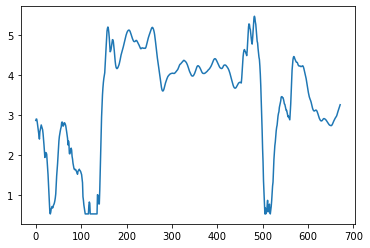

In [48]:
plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')

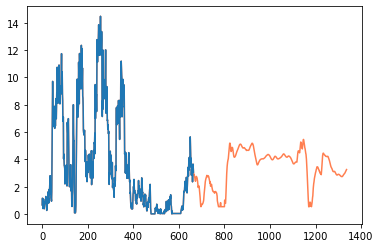

In [49]:
#绘制整体发电量图
total = np.hstack((df_y,y_pred_future_30_days))
plt.plot(range(len(total)), total, label='Prediction',color='coral')
plt.plot(range(len(df_y)), df_y, label='Prediction')

In [50]:
array1

array([array([[0.23481193]], dtype=float32),
       array([[0.23840894]], dtype=float32),
       array([[0.23814803]], dtype=float32),
       array([[0.23216309]], dtype=float32),
       array([[0.22351794]], dtype=float32),
       array([[0.21434455]], dtype=float32),
       array([[0.20492853]], dtype=float32),
       array([[0.1954991]], dtype=float32),
       array([[0.18799822]], dtype=float32),
       array([[0.20640828]], dtype=float32),
       array([[0.21248142]], dtype=float32),
       array([[0.2182597]], dtype=float32),
       array([[0.22345331]], dtype=float32),
       array([[0.21968724]], dtype=float32),
       array([[0.2166854]], dtype=float32),
       array([[0.21166505]], dtype=float32),
       array([[0.20206526]], dtype=float32),
       array([[0.18949398]], dtype=float32),
       array([[0.1741045]], dtype=float32),
       array([[0.15789822]], dtype=float32),
       array([[0.14172472]], dtype=float32),
       array([[0.1513697]], dtype=float32),
       array([[

In [51]:
array2=array1.copy()

In [52]:
array2[array2 < 0]= 0

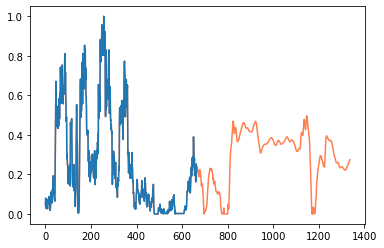

In [53]:
#绘制整体发电量图
total1 = np.hstack((df_scaled_y,array2))
plt.plot(range(len(total)), total1, label='Prediction',color='coral')
plt.plot(range(len(df_scaled_y)), df_scaled_y, label='Prediction')